jupyter nbconvert PyParsing.ipynb --to slides --post serve

# Introduction to Pyparsing

## Brian A. Fannin

## Installation

http://pyparsing.wikispaces.com/
http://infohost.nmt.edu/tcc/help/pubs/pyparsing/web/index.html

Support for Python < 2.6 requires installing a specific version. For anything else, >= 2.6 and 3.x, you're good to go. 

```
pip install pyparsing
```

In [20]:
from pyparsing import *

In [21]:
ssn = (
      Word(nums, exact=3) 
    + Literal("-") 
    + Word(nums, exact=2) 
    + Literal('-') 
    + Word(nums, exact=4))

ssn.parseString('555-55-5555')

(['555', '-', '55', '-', '5555'], {})

In [22]:
print(ssn.parseString('555-55-5555'))

['555', '-', '55', '-', '5555']


In [23]:
ssn = Combine(
      Word(nums, exact=3) 
    + Literal("-") 
    + Word(nums, exact=2) 
    + Literal('-') 
    + Word(nums, exact=4))

list(ssn.parseString('555-55-5555'))

['555-55-5555']

The value returned from a call to parseString is an object of class `pyparsing.ParseResults`.

In [24]:
mojo = ssn.parseString('555-55-5555')
type(mojo)

pyparsing.ParseResults

In [25]:
mojo

(['555-55-5555'], {})

In [26]:
print(mojo)

['555-55-5555']


In [27]:
some_text = """
    Jane Doe's social security number is 888-88-8888 and 
    Bob's is 333-33-3333. I'm not sure what Steve's number is.
    I think it starts with 123-45.
"""

print(ssn.searchString(some_text))

[['888-88-8888'], ['333-33-3333']]


In [28]:
ssn.setParseAction(lambda toks: toks[0].replace('-', ''))
print(ssn.parseString('555-55-5555'))

['555555555']


In [29]:
strip_dash = lambda toks: toks[0].replace("-", "")
convert_int = lambda toks: int(toks[0])
ssn.setParseAction(strip_dash, convert_int)
mojo = ssn.parseString('555-55-5555')
mojo

([555555555], {})

In [30]:
ssn = ssn.setResultsName("ssn")
mojo = ssn.parseString('555-55-5555')
mojo.ssn

555555555

In [31]:
mojo = ssn.parseString('555-55-5555').ssn
print('The value for mojo is {} and its type is {}.'.format(mojo, type(mojo)))

The value for mojo is 555555555 and its type is <class 'int'>.


In [32]:
mojo = ssn.searchString(some_text)
ssns = [soc.ssn for soc in mojo]
ssns

[888888888, 333333333]

In [33]:
strip_comma = lambda toks: toks[0].replace(",", "")

decimal_number = (
      Word(nums, nums + ",") 
    + Optional(Literal(".") + Word(nums)))
    
units = Word(alphas, alphas + ".")

observation = (
      decimal_number.setResultsName('measure').setParseAction(strip_comma, convert_int)
    + units.setResultsName('units')
)

test_strs = [
    '32 ft.',
    '48 feet',
    '14 meters',
    '1,000 yards',
]

print(observation.parseString(test_strs[0]))

[32, 'ft.']


In [34]:
observation.parseString(test_strs[0]).measure

32

In [35]:
obs = [observation.parseString(ob).measure for ob in test_strs]
obs

[32, 48, 14, 1000]

In [36]:
units = [observation.parseString(ob).units for ob in test_strs]
units

['ft.', 'feet', 'meters', 'yards']

## Data in the wild

Let's use pyparsing to churn through some random HTML. I love Michael Caine, but I hate trolling the IMDB site. We'll build a parser that will strip interesting things from IMDB. (Yes, we could use Beautiful Soup for this.)

[Michael Caine on IMDB](http://www.imdb.com/name/nm0000323/)

In [37]:
import requests

response = requests.get('http://www.imdb.com/name/nm0000323/')
response.status_code

200

In [38]:
len(response.text)

261837

In [39]:
response.text[:1000]

'\n\n\n\n\n<!DOCTYPE html>\n<html\nxmlns:og="http://ogp.me/ns#"\nxmlns:fb="http://www.facebook.com/2008/fbml">\n    <head>\n        <meta charset="utf-8">\n        <meta http-equiv="X-UA-Compatible" content="IE=edge">\n\n    <meta name="apple-itunes-app" content="app-id=342792525, app-argument=imdb:///name/nm0000323?src=mdot">\n            <script type="text/javascript">var ue_t0=window.ue_t0||+new Date();</script>\n            <script type="text/javascript">\n                var ue_mid = "A1EVAM02EL8SFB"; \n                var ue_sn = "www.imdb.com";  \n                var ue_furl = "fls-na.amazon.com";\n                var ue_sid = "000-0000000-0000000";\n                var ue_id = "1KB2QEH3ZQKMGC7CNQC3";\n                (function(e){var c=e;var a=c.ue||{};a.main_scope="mainscopecsm";a.q=[];a.t0=c.ue_t0||+new Date();a.d=g;function g(h){return +new Date()-(h?0:a.t0)}function d(h){return function(){a.q.push({n:h,a:arguments,t:a.d()})}}function b(m,l,h,j,i){var k={m:m,f:l,l:h,c:""+j,e

```
<div class="filmo-row even" id="actor-tt5013056">
<span class="year_column">
&nbsp;2017
</span>
<b><a href="/title/tt5013056/?ref_=nm_flmg_act_2">Dunkirk</a></b>
<br>
Radio Communication
(voice, uncredited)
</div>
```

In [40]:
div_start, div_end = makeHTMLTags("div")

divs = div_start.searchString(response.text)
print(divs[0])

['div', ['id', 'wrapper'], False]


In [41]:
print(divs[1])

['div', ['id', 'root'], ['class', 'redesign'], False]


In [42]:
print(divs[1]['class'])

redesign


We need to do two things:

1. Make sure that the div has a key for the class
2. Check that the class corresponds to a film entry

In [43]:
film_divs = []
for div in divs:
    try:
        the_class = div['class']
    except:
        continue
    print(the_class)
    film_divs.append(div)
    
len(film_divs)

redesign
navbarSprite
navbarSprite
magnifyingglass navbarSprite
quicksearch_dropdown_wrapper
sub_nav
subNavListContainer
subNavListContainer
sub_nav
subNavListContainer
subNavListContainer
sub_nav
subNavListContainer
subNavListContainer
sub_nav
imdb-pro-ad sub_nav
imdb-pro-ad__image
pagecontent
redesign
maindetails_center
article name-overview
image
meter-collapsed up three-line
meterToggleOnHover
meterToggleOnHover
meterToggleOnHover
infobar
txt-block
name-trivia-bio-text
inline
txt-block
pro-list
mediastrip_container
mediastrip
see-more
maindetails_sidebar
aux-content-widget-3 links subnav
split_0
split_1
show_more
show_less
aux-content-widget-2
ab_ninja
widget_content no_inline_blurb
widget_nested
ninja_image_pack
ninja_center
ninja_image first_image last_image
widget_image
image
widget_caption caption_overlay
primary
onoverflow
aux-content-widget-2
social
social_networking
social_networking_like
aux-content-widget-2
news_item odd
news_item even
news_item odd
see-more
aux-content-wi

907

In [44]:
filmo_class = (
    Literal('filmo-row') 
    + (Literal('even') | Literal('odd'))
).setParseAction(lambda toks: ' '.join(toks))

filmo_class.parseString("filmo-row even")

(['filmo-row even'], {})

In [45]:
film_divs = []
for div in divs:
    try:
        div_class = div['class']
    except:
        continue
    
    try:
        film_class = filmo_class.parseString(div_class)
        film_divs.append(div)
    except:
        continue

len(film_divs)

462

In [46]:
(
    164 + 
    7 +
    5 +
    1 +
    1 +
    4 +
    224 +
    56)

462

## Span for year

```
<span class="year_column">
&nbsp;2017
</span>
```


In [47]:
span_start, span_end = makeHTMLTags("span")
year = Word(nums, exact=4)

span_year = (
      Suppress(span_start) 
    + Suppress(SkipTo(year)) 
    + year + Optional(Word(alphas + '/' +'-'))
    + Suppress(span_end))

span_year.setParseAction(lambda toks: int(toks[0]))
span_year = span_year.setResultsName('year')

years = span_year.searchString(response.text)
len(years)

427

In [48]:
span_start, span_end = makeHTMLTags("span")
year = Word(nums, exact=4) + Optional(Word(alphas + '/' +'-', exact=2))
year_range = Combine(year + Literal("-") + year)
year_value = Or([year, year_range])

span_year = (
      Suppress(span_start) 
    + Suppress(SkipTo(year_value)) 
    + year_value
    + Suppress(span_end))

span_year.setParseAction(lambda toks: int(toks[0][:4]))
span_year = span_year.setResultsName('year')

In [49]:
years = span_year.searchString(response.text)
len(years)

462

In [50]:
years[:10]

[([2017], {'year': [(2017, 0)]}),
 ([2017], {'year': [(2017, 0)]}),
 ([2017], {'year': [(2017, 0)]}),
 ([2016], {'year': [(2016, 0)]}),
 ([2015], {'year': [(2015, 0)]}),
 ([2015], {'year': [(2015, 0)]}),
 ([2015], {'year': [(2015, 0)]}),
 ([2014], {'year': [(2014, 0)]}),
 ([2014], {'year': [(2014, 0)]}),
 ([2014], {'year': [(2014, 0)]})]

## Anchor tags

In [51]:
a_start, a_end = makeHTMLTags("a")

film_anchor = Suppress(a_start) + SkipTo(a_end) + Suppress(a_end)
film_anchor = film_anchor.setResultsName('title')

## Putting it all together

```
<div class="filmo-row even" id="actor-tt5013056">
<span class="year_column">
&nbsp;2017
</span>
<b><a href="/title/tt5013056/?ref_=nm_flmg_act_2">Dunkirk</a></b>
<br>
Radio Communication
(voice, uncredited)
</div>
```

In [52]:
film_div = (
      div_start
    + span_year 
    + Suppress(SkipTo(film_anchor))
    + film_anchor
    + SkipTo(div_end)
)

film_divs = film_div.searchString(response.text)
len(film_divs)

462

In [53]:
film_divs[0].year

2017

In [54]:
film_divs[0].title

(["Coup d'Etat"], {})

In [55]:
years = [film.year for film in film_divs]
years[:5]

[2017, 2017, 2017, 2016, 2015]

In [56]:
films = [str(film.title) for film in film_divs]
films[:5]

['["Coup d\'Etat"]',
 "['Dunkirk']",
 "['Going in Style']",
 "['Now You See Me 2']",
 "['The Last Witch Hunter']"]

In [57]:
import pandas as pd

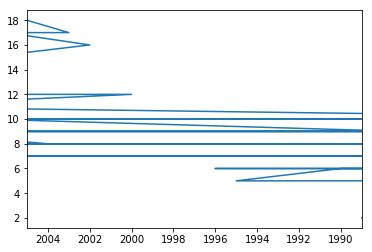

In [59]:
%matplotlib inline
years = pd.Series(years)

years.value_counts().plot()

In [40]:
import matplotlib.pyplot as plt

## A shiny new nickel to anyone who can tell me how to create a histogram in Python!

In [ ]:
plt.hist()